# House Price Prediction (Regression) 🏠

**Project Objective:** To build a regression model that accurately predicts the sale price of houses based on a large number of features. This project will cover the complete machine learning workflow, from deep EDA to advanced preprocessing, feature engineering, model training, and evaluation.

### Step 1: Setup - Importing Libraries

In [69]:
#!pip install xgboost

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
import os

### Step 2: Data Loading 

The data is downloaded from the Kaggle competition and stored in the local drive for model building

In [37]:
# loading the data into dataframe
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [38]:
# Set the Id column as the index for the consistency
train_df.set_index('Id', inplace=True)
test_df.set_index('Id', inplace = True)

print(f'Training data shape:{train_df.shape}')
print(f'Test data shape: {test_df.shape}')

Training data shape:(1460, 80)
Test data shape: (1459, 79)


In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

### Step 3: Deep Dive EDA on the Target Variable (`SalePrice`)

The most important variable in our dataset is the one we want to predict. Understanding its characteristics is the first and most critical step in any regression problem.

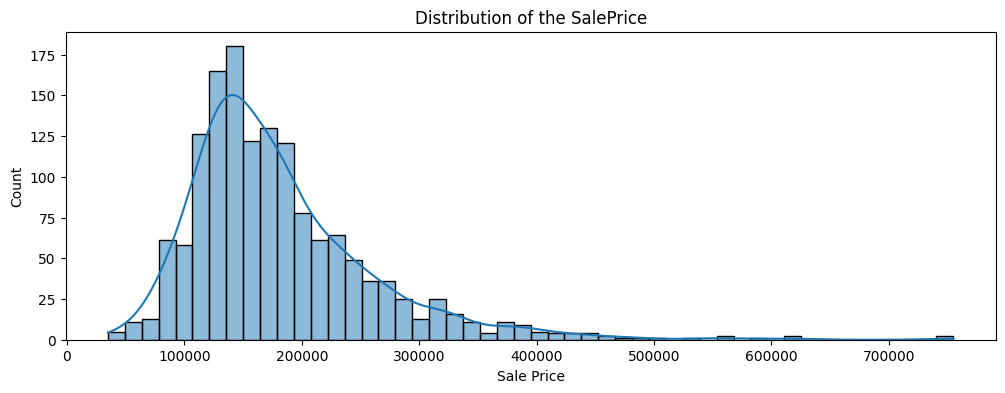

Skewness of Sale Price : 1.8828757597682129


In [40]:
# Plotting the distribution of the saleprice
plt.figure(figsize = (12,4))
sns.histplot(data = train_df, x='SalePrice', bins=50, kde = True)
plt.title('Distribution of the SalePrice')
plt.xlabel('Sale Price')
plt.show()

print(f'Skewness of Sale Price : {train_df.SalePrice.skew()}')

The distribution of `SalePrice` is **positively skewed** (or right-skewed). This means there's a long tail of very expensive houses, which can negatively impact the performance linear models like Linear Regression. These models often assume that the variables (and especially the residuals of the model) are normally distributed.

To fix this, we will try applying a **log transformation** (`np.log1p`, which is `log(1+x)` to handle potential zero values). This transformation compresses the range of large values, making the distribution more symmetrical and closer to a normal distribution.

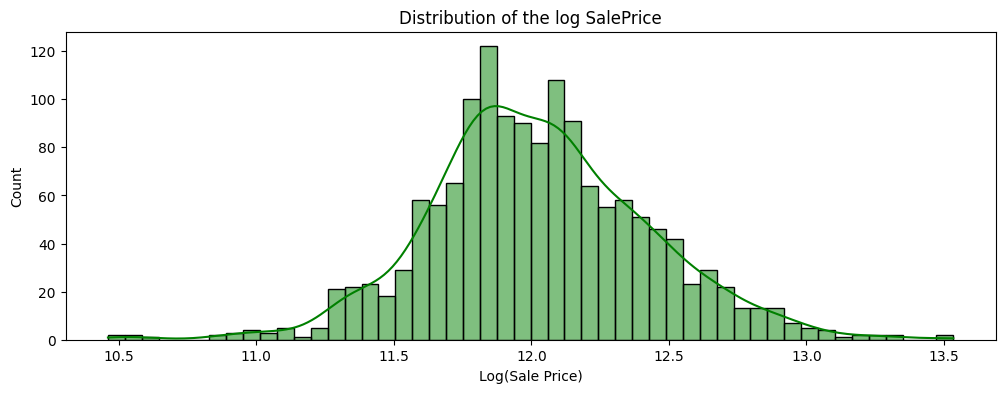

Skewness of Log Sale Price : 0.12134661989685333


In [41]:
train_df.SalePrice = np.log1p(train_df.SalePrice)

# Plotting the distribution of the log of saleprice
plt.figure(figsize = (12,4))
sns.histplot(data = train_df, x='SalePrice', bins=50, kde = True, color='green')
plt.title('Distribution of the log SalePrice')
plt.xlabel('Log(Sale Price)')
plt.show()

print(f'Skewness of Log Sale Price : {train_df.SalePrice.skew()}')

**Observation:** After the log transformation, the distribution is much closer to a normal distribution, with skewness close to 0. I will build my model to predict the log of the price, and then convert it back to the original scale for my final predictions.

### Step 4: EDA on Feature Variables

In [42]:
# Identify the top 10 feature most correlated with Saleprice
corrmat = train_df.corr(numeric_only = True)
corrmat

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.073959
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.355879
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.257320
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.817185
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.036868
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.586570
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.565608
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.430809
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.372023
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,0.004832


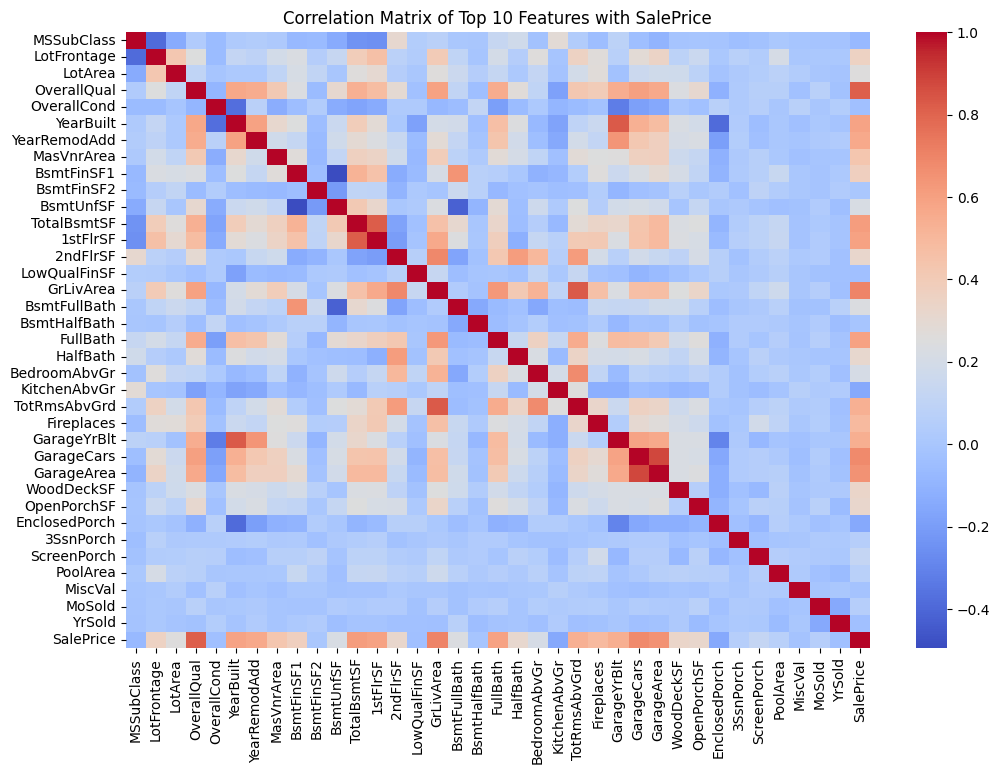

In [43]:
# Plotting the corrmar in the form of heatmap
plt.figure(figsize = (12,8))
sns.heatmap(corrmat, cmap='coolwarm')
plt.title('Correlation Matrix of Top 10 Features with SalePrice')
plt.show()

In [44]:
# Extracting the top corrmat matrix
top_corr_features = corrmat.nlargest(15, 'SalePrice')['SalePrice'].index
top_corr_matrix = train_df[top_corr_features].corr()
top_corr_matrix

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,GarageYrBlt,TotRmsAbvGrd,Fireplaces,MasVnrArea,BsmtFinSF1
SalePrice,1.000000,0.817185,0.700927,0.680625,0.650888,0.612134,0.596981,0.594771,0.586570,0.565608,0.541073,0.534422,0.489450,0.430809,0.372023
OverallQual,0.817185,1.000000,0.593007,0.600671,0.562022,0.537808,0.476224,0.550600,0.572323,0.550684,0.547766,0.427452,0.396765,0.411876,0.239666
GrLivArea,0.700927,0.593007,1.000000,0.467247,0.468997,0.454868,0.566024,0.630012,0.199010,0.287389,0.231197,0.825489,0.461679,0.390857,0.208171
GarageCars,0.680625,0.600671,0.467247,1.000000,0.882475,0.434585,0.439317,0.469672,0.537850,0.420622,0.588920,0.362289,0.300789,0.364204,0.224054
GarageArea,0.650888,0.562022,0.468997,0.882475,1.000000,0.486665,0.489782,0.405656,0.478954,0.371600,0.564567,0.337822,0.269141,0.373066,0.296970
TotalBsmtSF,0.612134,0.537808,0.454868,0.434585,0.486665,1.000000,0.819530,0.323722,0.391452,0.291066,0.322445,0.285573,0.339519,0.363936,0.522396
1stFlrSF,0.596981,0.476224,0.566024,0.439317,0.489782,0.819530,1.000000,0.380637,0.281986,0.240379,0.233449,0.409516,0.410531,0.344501,0.445863
FullBath,0.594771,0.550600,0.630012,0.469672,0.405656,0.323722,0.380637,1.000000,0.468271,0.439046,0.484557,0.554784,0.243671,0.276833,0.058543
YearBuilt,0.586570,0.572323,0.199010,0.537850,0.478954,0.391452,0.281986,0.468271,1.000000,0.592855,0.825667,0.095589,0.147716,0.315707,0.249503
YearRemodAdd,0.565608,0.550684,0.287389,0.420622,0.371600,0.291066,0.240379,0.439046,0.592855,1.000000,0.642277,0.191740,0.112581,0.179618,0.128451


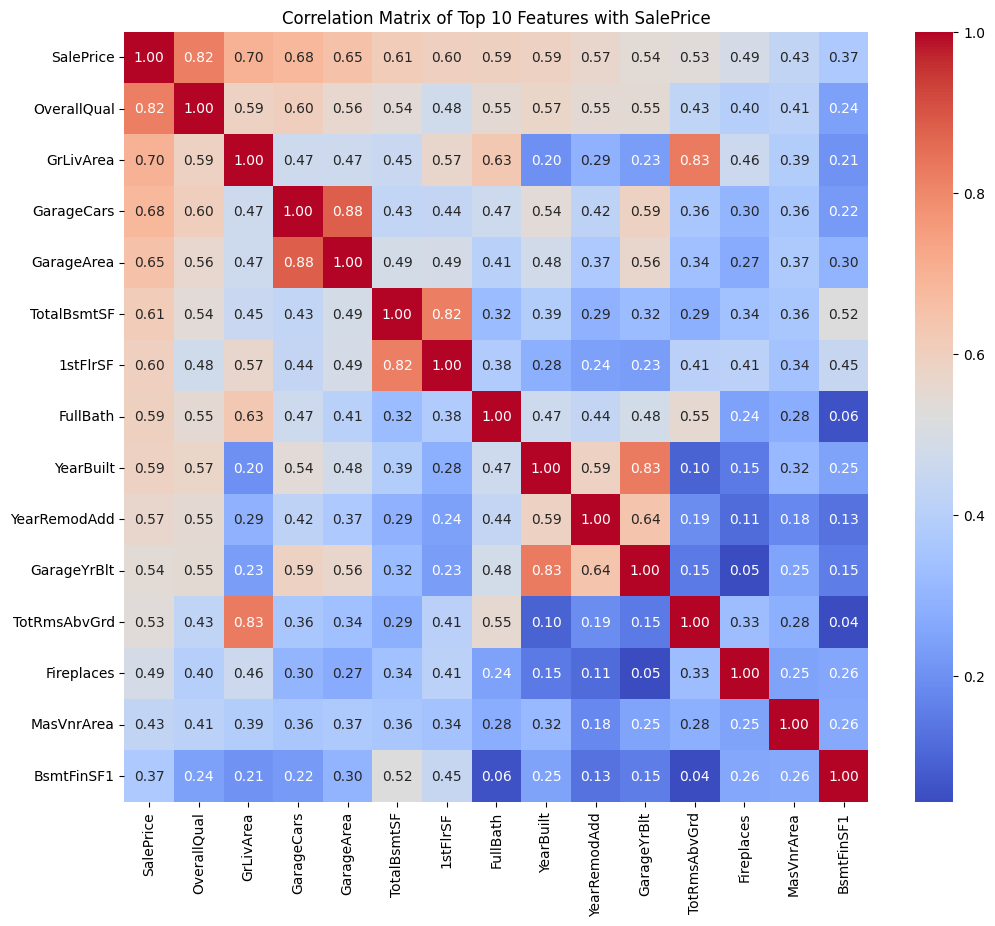

In [45]:
# Plotting the top_corr_martix in the form of matrix
plt.figure(figsize = (12,10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Top 10 Features with SalePrice')
plt.show()

**Insight:** The heatmap shows that `OverallQual` (Overall Quality), `GrLivArea` (Above Ground Living Area), and `GarageCars`/`GarageArea` are the most positively correlated features with `SalePrice`. This makes intuitive sense—better quality, larger houses with bigger garages tend to be more expensive.

### Step 5: Data Preprocessing & Feature Engineering

Handel the missing vlaues, create new features, and encode categorical variables to prepare the data for modeling.

In [46]:
# Combining the train and the test dataset for processing
all_data = pd.concat((train_df.loc[:,:'SaleCondition'],test_df.loc[:,:'SaleCondition']))

print(f'All data shape :{ all_data.shape}')

All data shape :(2919, 79)


Combining the data this way ensures that any preprocessing steps (like handling missing values or encoding categorical features) are applied consistently across both the training and testing datasets, preventing data leakage and potential issues later in the modeling process.

#### 5.1 Handling Missing Values

##### **5.1.1 - Handling Missing Values for numerical columns**

In [47]:
# Find missing values in the current all_data
missing_data = all_data.isnull().sum().sort_values(ascending = False)
missing_data = missing_data[missing_data > 0]

print('Features with missing values')
print(missing_data)

Features with missing values
PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Functional         2
BsmtFullBath       2
Utilities          2
Exterior1st        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF1         1
SaleType           1
KitchenQual        1
GarageCars         1
GarageArea         1
Electrical         1
Exterior2nd        1
BsmtFinSF2         1
dtype: int64


In [48]:
# Extract numerical columns
numerical_cols = all_data.select_dtypes(include=[np.number]).columns.tolist()

# Get index of missing data
missing_data_index = missing_data.index

# Identify numerical columns that are in the missing data index
numerical_cols_to_impute_zero = [col for col in numerical_cols if col in missing_data_index]

print(all_data[numerical_cols_to_impute_zero].isnull().sum())


LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64


In [49]:
numerical_cols_to_impute_zero.remove('LotFrontage')
numerical_cols_to_impute_zero.remove('GarageYrBlt')

In [50]:

# Imputing numerical features with 0 except `LotFrontage` and `GarageYrBlt` since the 
# count of missing vlaue are minimal (mostly one missing value)
for col in numerical_cols_to_impute_zero:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)


In [51]:
# Check missing values in numerical columns after imputation with 0 
all_data[numerical_cols_to_impute_zero].isnull().sum()

MasVnrArea      0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
GarageCars      0
GarageArea      0
dtype: int64

In [52]:
# Imputing the missing value for GarageYrBlt (Year the garage was built)
# GarageYrBlt can be imputed with 0 (assuming 0 means no garage, consistent with GarageArea/Cars=0)

if 'GarageYrBlt' in all_data.columns:
    all_data.GarageYrBlt = all_data.GarageYrBlt.fillna(0)

##### **5.1.2 Handling Missing Values for categorical columns**

In [53]:
# Checking the missing values in the current all_data
missing_data = all_data.isnull().sum().sort_values(ascending = False)
missing_data = missing_data[missing_data > 0]

print('Features with missing values')


# Imputing the categorical features with "None" (for features where NA means no)
# Imputing the features with Mode where NA means missing value
categorical_cols_to_impute_none = ['Alley', 'Fence', 'MiscFeature', 
                                   'PoolQC', 'FireplaceQu', 'GarageType', 
                                   'GarageFinish', 'GarageQual', 'GarageCond',
                                   'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                                   'BsmtFinType1', 'BsmtFinType2', 
                                   'MasVnrType']
for col in categorical_cols_to_impute_none:
    if col in all_data.columns: # Check if column exists after one-hot encoding
        all_data[col] = all_data[col].fillna('None')

for col in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 
            'SaleType', 'Utilities', 'Functional', 'MSZoning']:
    if col in all_data.columns: # Check if column exists after one-hot encoding
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
print(missing_data)

Features with missing values
PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MSZoning           4
Functional         2
Utilities          2
Electrical         1
SaleType           1
KitchenQual        1
Exterior2nd        1
Exterior1st        1
dtype: int64


In [54]:
# LotFrontage is the Linear feet of street connected to property.
# Imputing this value with the median of the neighbourhood
if 'LotFrontage' in all_data.columns and all_data.LotFrontage.isnull().any():
    all_data.LotFrontage = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

In [55]:
#Verifying of all the missing values are imputed
missing_data = all_data.isnull().sum().sort_values(ascending = False)
missing_data = missing_data[missing_data > 0]

print('Features with missing values')
print(missing_data)

Features with missing values
Series([], dtype: int64)


### Step 6: Feature engineering

Creating the following new features based on the available features
**Total Square Feet** combine the toal area of the construction
**Total Bath** combine the total bath area
**Age** create the age of the building from year built to year sold

In [56]:
# Creating the total Area feature
all_data['TotalSF'] = all_data.TotalBsmtSF + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Creating total bathroom feature
all_data['TotalBath'] = (all_data.FullBath+(0.5 * all_data.HalfBath) + 
                         all_data.BsmtFullBath + (0.5 * all_data.BsmtHalfBath))

#Created a feature for age of the housing at sale
all_data["Age"] = all_data.YrSold - all_data.YearBuilt

### Step 7: Categorical encoding

In [57]:
print(f"Data shape before encoding: {all_data.shape}")

Data shape before encoding: (2919, 82)


In [58]:
# Converting the object columns to category type for one-hot encoding
categorical_cols = all_data.select_dtypes(include=['object']).columns
all_data = pd.get_dummies(all_data, columns=categorical_cols, drop_first=True)

print(f"Data shape after encoding: {all_data.shape}")

Data shape after encoding: (2919, 262)


### Step 8: Model Building & Training

Creating the training and testing split for modelbuilding

In [59]:
# Separate the preprocessed data back into the training and the tesing sets
X= all_data[:len(train_df)]
y= train_df['SalePrice'] # SalePrice was already log-transformed in train_df
X_test_final = all_data[len(train_df):]

# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.2, random_state = 42)


##### **Standardization of the numerial features**

In [60]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_final_scaled = scaler.transform(X_test_final)

In [61]:
X.shape

(1460, 262)

#### 8.1 Model 1: Linear Regression

In [62]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr=lr.predict(X_val_scaled)

#### 8.2 Model 2: Decision tree

In [63]:
dt_regr= DecisionTreeRegressor()
dt_regr.fit(X_train_scaled, y_train)
y_pred_dt = dt_regr.predict(X_val_scaled)

#### 8.3 Model 2: Support Vector Machines

In [64]:
svm= svm.SVR()
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_val_scaled)

#### 8.4 Model 2: XGBoost

In [65]:
xgbr = xgb.XGBRegressor(objective = 'reg:squarederror',
                        n_estimators = 1000,
                        learning_rate = 0.05,
                        max_depth = 3,
                        min_child_weight = 1,
                        subsample = 0.8,
                        colsample_bytree = 0.8,
                        random_state = 42
                       )
xgbr.fit(X_train_scaled, y_train)
y_pred_xgb = xgbr.predict(X_val_scaled)

### Step 9: Model Evaluation

Evaluating the model using the below criteria
- **Mean Absolute Error (MAE)** - The average differance between the predicted and actual vallue
- **Mean Suared Error (MSE)** - The average of the squared error
- **Root Mean Square(RMSE)** - The square root of MSE
- **R - Square ($R^2$)** - 

In [66]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    print(f"-------{model_name} Performance------")
    print(f'RMSE : {rmse:.4f}')
    print(f'MAE :{mae:.4f}')
    print(f'R-Square :{r2:.4f}\n')
    

In [67]:
# Evaluating Linear regression
evaluate_model(y_val,y_pred_lr,"Linear Regression")
# Evaluating Decision tree
evaluate_model(y_val,y_pred_dt,"Decission Tree")
# Evaluating SVM
evaluate_model(y_val,y_pred_svm,"Decission Tree")
# Evaluating XGboost
evaluate_model(y_val,y_pred_xgb,"XGBoost")

-------Linear Regression Performance------
RMSE : 0.1734
MAE :0.0960
R-Square :0.8389

-------Decission Tree Performance------
RMSE : 0.2066
MAE :0.1448
R-Square :0.7712

-------Decission Tree Performance------
RMSE : 0.2148
MAE :0.1285
R-Square :0.7528

-------XGBoost Performance------
RMSE : 0.1335
MAE :0.0860
R-Square :0.9045



**Observation:** The XGBoost model significantly outperforms the Linear Regression model on all metrics. It has a lower error (RMSE, MAE) and explains a higher proportion of the variance (R-squared). This is expected, as gradient boosting models are more powerful and can capture complex, non-linear relationships in the data.

Step : Generating the output of the test data

### Step 10: Generating the ouptut data

In [68]:
# Makeing predictions on the final test set using the best model (XGBoost)
# Use the unscaled test data for XGBoost prediction

final_prediction_log = xgbr.predict(X_test_final)

# IMPORTANT: We must reverse the log transformation to get the predictions back on the original price scale
final_predictions = np.expm1(final_prediction_log)

# Create the Output DataFrame
Output = pd.DataFrame({'Id': test_df.index, 'SalePrice': final_predictions})

print("Output Sales price on the test data")
Output.head()


Output Sales price on the test data


,Id,SalePrice
0,1461,268519.84375
1,1462,269659.00000
2,1463,317155.46875
3,1464,326167.53125
4,1465,312097.87500


### Step 11: Conclusion

In this project, we successfully built an end-to-end regression pipeline to predict house prices.

**Key Steps Undertaken:**
1.  **Analyzed and transformed the target variable** (`SalePrice`) to handle its skewness.
2.  Conducted a **thorough EDA** to understand the key features influencing price.
3.  Implemented a **robust preprocessing strategy**, handling various types of missing data and encoding categorical features correctly.
4.  **Engineered new features** (`TotalSF`, `TotalBath`, `Age`) that provided more predictive power.
5.  **Trained and compared multiple models**, demonstrating the superior performance of XGBoost over a simple linear model, Decision Tree and SVM.
6.  **Evaluated the models** using standard regression metrics and generated a final Output file.

**Potential Next Steps:**
- **Hyperparameter Tuning:** Use techniques like GridSearchCV to find the optimal parameters for the XGBoost model.
- **More Feature Engineering:** Create more complex features, such as interaction terms between key variables.
- **Ensemble Modeling:** Combine the predictions of several different models to potentially achieve even better results.